In [1]:
%load_ext autoreload
%autoreload 2

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from multiprocess import Pool, cpu_count

from fem2D import *
from squareMesh import squareMesh

nprocesses = cpu_count()
print(f"Code parallelized with {nprocesses} processes.")

Code parallelized with 12 processes.


In [3]:
# construction du maillage

L = 100.0   # square size
dx = 10.0    # elements size

eraseCurrentMesh()

elements, nodes = squareMesh(L,dx)

dof = len(nodes)
print(f"{dof=}")

dof=121


<AxesSubplot:>

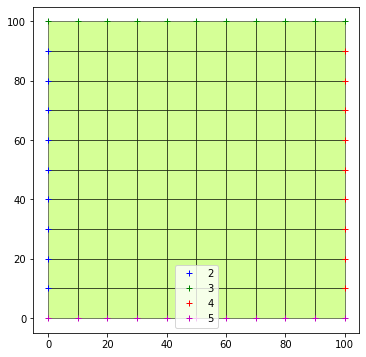

In [4]:
plotMesh(elements, nodes, [2,3,4,5])

In [5]:
# définition des interpolateurs (P1 : linéaire) et de ses dérivées partielles

Nelem = 4

phi = [
    lambda u,v : 0.25*(1-u)*(1-v), # (-1,-1)
    lambda u,v : 0.25*(1+u)*(1-v), # (+1,-1)
    lambda u,v : 0.25*(1+u)*(1+v), # (+1,+1)
    lambda u,v : 0.25*(1-u)*(1+v), # (-1,+1)
]

duphi = [
        lambda u,v : -0.25*(1-v),   # (-1,-1)
        lambda u,v : 0.25*(1-v),    # (+1,-1)
        lambda u,v : 0.25*(1+v),   # (-1,+1)
        lambda u,v : -0.25*(1+v),   # (+1,+1)
]
dvphi = [
        lambda u,v : -0.25*(1-u),   # (-1,-1)
        lambda u,v : -0.25*(1+u),   # (+1,-1)
        lambda u,v : 0.25*(1+u),    # (-1,+1)
        lambda u,v : 0.25*(1-u),    # (+1,+1)
]

gradphi = [
        lambda u,v: np.array([duphi[i](u,v), dvphi[i](u,v)])
        for i in range(4)
]

# fonction retournant l'interpolateur selon les 4 fonctions phi pour les 4 valeurs aux noeuds X
def interp(phiList, X):
    return lambda u,v : sum([phi(u,v)*x for phi,x in zip(phiList, X)])

In [6]:
# Pour chaque élément calcul:
# - du jacobien
# - de l'inverse de la matrice jacobienne

for e in elements:

    coords = e.getCoords()
    X, Y = coords[:,0], coords[:,1]

    dxdu = interp(duphi, X)
    dxdv = interp(dvphi, X)        
    dydu = interp(duphi, Y)
    dydv = interp(dvphi, Y)
    
    e.detJ = lambda u,v : dxdu(u,v)*dydv(u,v) - dxdv(u,v)*dydu(u,v)

    e.iJ = lambda u,v :  np.array(
        [[dydv(u,v), -dydu(u,v)],
        [-dxdv(u,v), dxdu(u,v)]]
    )/e.detJ(u,v)

In [7]:
# Détermination d'une règle de quadrature 

# nombre de points de quadrature (par dimension)
Nquad = 6

# importation poids et abscices Gauss-Legendre
data = np.loadtxt(f"../quadratureRules/gl_{Nquad:02d}.tab")
w_i, xi_i = data[:,0], data[:,1] 

# Compute the 2D integral of f(u,v) over [-1,1]x[-1,1]

int2D = lambda f: sum([ sum([w1*w2 * f(xi1, xi2) for xi1,w1 in zip(xi_i, w_i)]) for xi2,w2 in zip(xi_i, w_i)])

In [8]:
# Détermination des coefficients de Lamé

# pour du béton en compression
Young = 11
Poisson = 0.15

lambda_coef = (Young*Poisson) / ((1+Poisson)*(1-2*Poisson))
mu_coef = Young / (2*(1+Poisson))

D = np.array([[lambda_coef + 2*mu_coef, lambda_coef, 0], [lambda_coef, lambda_coef + 2*mu_coef, 0], [0, 0, mu_coef]])
D

array([[11.61490683,  2.04968944,  0.        ],
       [ 2.04968944, 11.61490683,  0.        ],
       [ 0.        ,  0.        ,  4.7826087 ]])

In [9]:
# Détermination des matrices pour l'élasticité
for e in tqdm(elements):
    
    BN1, BN2, BN3 = [], [], []
    for a in range(Nelem):
        BN1.extend([lambda u,v: e.iJ(u,v)[0,:]@gradphi[a](u,v), lambda u,v: 0])
        BN2.extend([lambda u,v: 0, lambda u,v: e.iJ(u,v)[1,:]@gradphi[a](u,v)])
        BN3.extend([lambda u,v: e.iJ(u,v)[0,:]@gradphi[a](u,v)/2, lambda u,v: e.iJ(u,v)[1,:]@gradphi[a](u,v)/2])
    e.BN = np.array([BN1, BN2, BN3], dtype=object)

100%|██████████| 100/100 [00:00<00:00, 15560.39it/s]


In [10]:
elements[4].BN.transpose().shape

(8, 3)

In [13]:
# Calcul des matrices élémentaires locales -> à optimiser

def computeKe(e):
    
    e.Ke = np.zeros((8,8))
    
    for i in range(8):
        for j in range(8):

            fk = lambda u,v: sum(sum( e.BN.transpose()[i,k](u,v) * D[k,h] * e.BN[h,j](u,v) *e.detJ(u,v) for k in range(3)) for h in range(3))
            e.Ke[i,j] = int2D(fk)
            
    return e

with Pool(nprocesses) as p:
    Element.id = 0
    elements = list(tqdm(p.imap(computeKe, elements), total=len(elements)))

100%|██████████| 100/100 [00:18<00:00,  5.48it/s]


In [15]:
# Calcule des matrices globales -> à optimiser
K = np.zeros((2*dof,2*dof))

for e in elements:
    for (i,n1) in enumerate(e.nodes):
        for (j,n2) in enumerate(e.nodes):
            
            K[2*(n1.id-1),2*(n2.id-1)] += e.Ke[2*i,2*j]
            K[2*(n1.id-1),2*(n2.id-1)+1] += e.Ke[2*i,2*j+1]
            K[2*(n1.id-1)+1,2*(n2.id-1)] += e.Ke[2*i+1,2*j]
            K[2*(n1.id-1)+1,2*(n2.id-1)+1] += e.Ke[2*i+1,2*j+1]

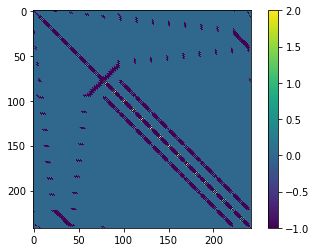

In [16]:
plt.imshow(K, vmin=-1, vmax=2)
plt.colorbar()

In [17]:
# Conditions aux limites

F = np.zeros(2*dof)
boundary = 2
boundary_list = []
shift = [1, 0]

for n in nodes:
    if n.region == boundary:
        #K[n.id-1,:] = 0
        #K[n.id-1, n.id-1] = 1
        F[2*(n.id-1)] = shift[0]
        F[2*(n.id-1)+1] = shift[1]

In [18]:
# Résolution du système

U = np.linalg.solve(K, F)

LinAlgError: Singular matrix

In [ ]:
def plotNodesValues(U, nodes, ax):
    dots = ax.scatter([n.x for n in nodes], [n.y for n in nodes], c=U, zorder=5)
    plt.colorbar(dots)
    ax.set_aspect("equal", "box")
    
def plotMeshLimits(elements, ax):
    for e in elements:
        coords = e.getCoords()
        ax.fill(coords[:,0], coords[:,1], facecolor="none", ec="k", zorder=1)

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))


plotNodesValues(U, nodes, ax)
plotMeshLimits(elements, ax)

In [ ]:
def plotBourrin(U, elements, ax, mesh=False):
        
    u = np.linspace(-1, 1, 10)
    uu, vv = np.meshgrid(u,u)
    
    vmin, vmax = U.min(), U.max()
    
    for e in elements:
        
        coords = e.getCoords()
        X, Y = coords[:,0], coords[:,1]
        
        zitp = interp(phi, [U[n.id] for n in e.nodes])
        xitp = interp(phi, X)
        yitp = interp(phi, Y)
        
        Z = zitp(uu, vv)
        X = xitp(uu, vv)
        Y = yitp(uu, vv)
        
        dots = plt.scatter(X, Y, marker=",", c = Z, vmin=vmin, vmax=vmax)
    
    plt.colorbar(dots)
    
    if mesh:
        for e in elements:
            n1,n2,n3,n4 = e.nodes        
            plt.plot([n1.x,n2.x], [n1.y,n2.y], "k", lw=0.5)
            plt.plot([n2.x,n3.x], [n2.y,n3.y], "k", lw=0.5)
            plt.plot([n3.x,n4.x], [n3.y,n4.y], "k", lw=0.5)
            plt.plot([n4.x,n1.x], [n4.y,n1.y], "k", lw=0.5)
    
    ax.set_aspect("equal", "box")        

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))

plotBourrin(U, elements, ax)
plotMeshLimits(elements, ax)

In [ ]:
def quad2tri(e):
    n0, n1, n2, n3 = e.nodes
    return Element([n0, n1, n2]), Element([n2, n3, n0])

def plotFemResults(nodes, elements, U, ax):
    
    ax.set_aspect("equal", "box")        
    
    X = np.array([n.x for n in nodes])
    Y = np.array([n.y for n in nodes])
    elmtNodes = np.array([[n.id for n in e.nodes] for e in elements])
    levels = np.linspace(U.min(), U.max(), 100)
    
    im = ax.tricontourf(X, Y, elmtNodes, U, levels=levels) 
    plt.colorbar(im)

elementsTri = []
for e in elements:
    e1, e2 = quad2tri(e)
    elementsTri.append(e1)
    elementsTri.append(e2)


fig,ax = plt.subplots(figsize=(8,8))

plotFemResults(nodes, elementsTri, U, ax) 
plotMeshLimits(elements, ax)   